In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import pickle
from torch.utils.data import random_split
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import v2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('/kaggle/input/cifar10/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl')

# Extract images
images = cifar10_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

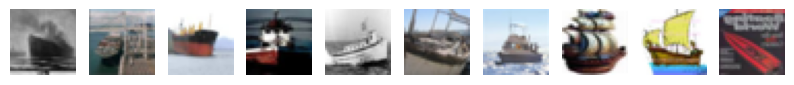

In [4]:
images = cifar10_batch[b'data']
# Reshape to (number of images, width, height, channels)
images = images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images with a larger size
plt.figure(figsize=(10, 5))  # Increase the figsize for larger display
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [5]:
class CIFAR10Dataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        
        if train:
            for i in range(1, 6):
                with open(os.path.join(root, f'data_batch_{i}'), 'rb') as file:
                    batch = pickle.load(file, encoding='latin1')
                    self.data.append(batch['data'])
                    self.labels.extend(batch['labels'])
            self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        else:
            with open(os.path.join(root, 'test_batch'), 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                self.data = batch['data']
                self.labels = batch['labels']
            self.data = self.data.reshape(-1, 3, 32, 32)
        
        self.data = self.data.transpose((0, 2, 3, 1))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx], self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
    
class CIFAR10Custom(Dataset):
    def __init__(self, pkl_file, transform=None):
        with open(pkl_file, 'rb') as file:
            data = pickle.load(file)
            self.data = data[b'data']
            self.ids = data[b'ids']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        img = np.reshape(img, (3, 32, 32)).astype('uint8')
        img = np.transpose(img, (1, 2, 0))

        if self.transform:
            img = self.transform(img)

        return img

# transformations
transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar10_dir = '/kaggle/input/cifar10/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'
custom_cifar10_dir = '/kaggle/input/cifar10/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl'

train_dataset = CIFAR10Dataset(cifar10_dir, train=True, transform=transform_train)
test_dataset = CIFAR10Dataset(cifar10_dir, train=False, transform=transform)
custom_test_dataset = CIFAR10Custom(custom_cifar10_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
validation_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
custom_test_loader = DataLoader(custom_test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [6]:
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )
  
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion      
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

def ResNet9():
    return ResNet(BasicBlock, [1, 1, 1, 1])

model = ResNet9().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]             256
       BasicBlock-14          [-1, 128,

Epoch 1/200
Training Loss: 1.6139, Validation Loss: 1.4141
Validation Accuracy: 58.98%
best model saved.
Epoch 2/200
Training Loss: 1.2973, Validation Loss: 1.2599
Validation Accuracy: 67.90%
best model saved.
Epoch 3/200
Training Loss: 1.1690, Validation Loss: 1.1804
Validation Accuracy: 72.05%
best model saved.
Epoch 4/200
Training Loss: 1.0894, Validation Loss: 1.0721
Validation Accuracy: 76.18%
best model saved.
Epoch 5/200
Training Loss: 1.0339, Validation Loss: 1.0228
Validation Accuracy: 79.31%
best model saved.
Epoch 6/200
Training Loss: 0.9962, Validation Loss: 0.9746
Validation Accuracy: 81.29%
best model saved.
Epoch 7/200
Training Loss: 0.9669, Validation Loss: 0.9603
Validation Accuracy: 82.15%
best model saved.
Epoch 8/200
Training Loss: 0.9436, Validation Loss: 0.9375
Validation Accuracy: 82.52%
best model saved.
Epoch 9/200
Training Loss: 0.9189, Validation Loss: 0.9609
Validation Accuracy: 81.61%
Epoch 10/200
Training Loss: 0.9033, Validation Loss: 0.8915
Validation Ac

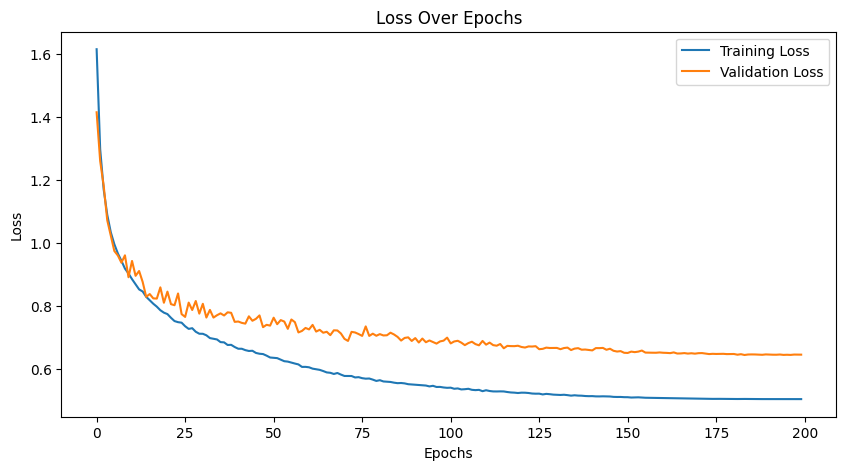

In [7]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=35e-5)
num_epochs = 200
steps_per_epoch = len(train_loader)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(train_loader), epochs=num_epochs)


best_loss = float('inf')
model_path = '/kaggle/working/'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        scheduler.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_loss /= len(validation_loader)
    validation_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    valid_losses.append(validation_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')
    print(f'Validation Accuracy: {validation_accuracy:.2f}%')
    
    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': validation_loss,
    }

    torch.save(checkpoint, os.path.join(model_path, 'last_checkpoint.pth'))

    if validation_loss < best_loss:
        best_loss = validation_loss
        best_model_path = os.path.join(model_path, 'best_model.pth')
        torch.save(checkpoint, best_model_path)
        print('best model saved.')

print('Finished Training')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
from tqdm import tqdm
import pandas as pd

best_model_path = '/kaggle/working/best_model.pth'
checkpoint = torch.load(best_model_path)

model_state_dict = checkpoint['state_dict']

model.load_state_dict(model_state_dict)

model.eval()

predictions = []
ids = []

with torch.no_grad():
    for images in tqdm(custom_test_loader, desc='Predicting'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

ids = [int(id_) for id_ in custom_test_dataset.ids]

submission_df = pd.DataFrame({'ID': ids, 'Labels': predictions})
submission_df.to_csv('submission.csv', index=False)

print("Prediction CSV file saved to '/kaggle/working/submission.csv'")

Predicting: 100%|██████████| 79/79 [00:01<00:00, 51.87it/s]

Prediction CSV file saved to '/kaggle/working/submission.csv'


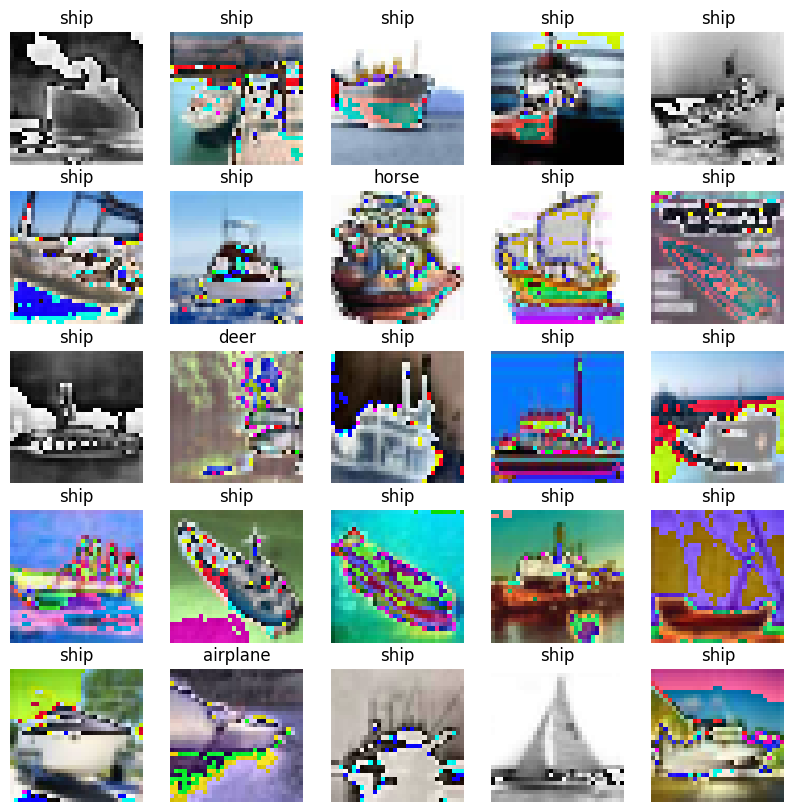

In [10]:
import matplotlib.pyplot as plt
import torch

label_names = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship", "truck"
]

def plot_images(images, predictions, nrows=5, ncols=5):
    plt.figure(figsize=(10, 10))
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(images[i])
        plt.title(label_names[predictions[i]])
        plt.axis('off')
    plt.show()

plot_images_list = []
plot_predictions = []

best_model_path = '/kaggle/working/best_model.pth'
checkpoint = torch.load(best_model_path)

model_state_dict = checkpoint['state_dict']

model.load_state_dict(model_state_dict)

model.eval()

image_counter = 0
start_image_index = 0
max_images = 25

plot_images_list = []
plot_predictions = []

model.eval()

with torch.no_grad():
    for images in iter(custom_test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().numpy()

        for i in range(images.size(0)):
            if image_counter >= max_images:
                break
            if image_counter >= start_image_index:
                pil_img = transforms.ToPILImage()(images[i].cpu())
                plot_images_list.append(pil_img)
                plot_predictions.append(predicted[i])
            
            image_counter += 1

        if image_counter >= max_images:
            break

plot_images(plot_images_list, plot_predictions)

<Axes: >

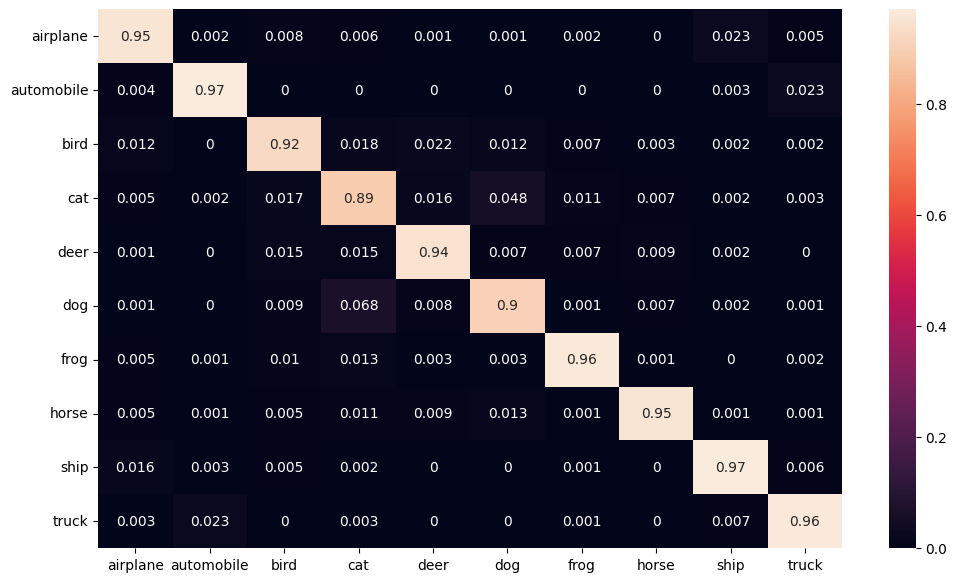

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

class_names = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship", "truck"
]
predicted_labels = []
actual_labels = []

model.eval()

with torch.no_grad():
  for images, labels in DataLoader(dataset=test_dataset, batch_size=1, num_workers=4):
    images, labels = images.to(device), labels.to(device)
    prediction_logits = model(images)
    predictions = prediction_logits.argmax(dim=1).cpu().numpy()
    predicted_labels.extend(predictions)
    true_labels = labels.cpu().numpy()
    actual_labels.extend(true_labels)

confusion_mat = confusion_matrix(actual_labels, predicted_labels)
confusion_df = pd.DataFrame(confusion_mat/np.sum(confusion_mat)*10, index=class_names, columns=class_names)
plt.figure(figsize=(12,7))
sn.heatmap(confusion_df, annot=True)

In [14]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=903cfba4c170f6cafba96769d616e9c972caf1d4a8b9644cdb9e37ecd5004e93
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [15]:
import torch
from torchviz import make_dot
import torch.nn as nn
import torch.nn.functional as F

def ResNet9():
    return ResNet(BasicBlock, [1, 1, 1, 1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet9().to(device)

dummy_input = torch.randn(1, 3, 32, 32, device=device)

output = model(dummy_input)

dot = make_dot(output, params=dict(model.named_parameters()))

dot.render("/kaggle/working/resnet9_visualization", format="png")

'/kaggle/working/resnet9_visualization.png'